<a href="https://colab.research.google.com/github/Prakhar967/Bike-Maintainence-2.0/blob/master/Predective_Bike_Maintainence.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.multioutput import MultiOutputClassifier
from xgboost import XGBClassifier
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
!pip install -U scikit-learn==1.7.2

In [ ]:
# 1. Loading dataset
df = pd.read_csv("/content/bike_predictive_maintenance_balanced.csv")

In [ ]:
df

,ride_id,avg_accel_magnitude,std_accel_magnitude,max_jerk,vibration_index,mean_speed,max_speed,total_distance_m,altitude_gain_m,num_stops,weather,timestamp_local,lat,lon,timezone,suspicious_flag,maintenance_log
0,115.948,0.470,0.215,0.042,0.083,4.638,4.560,2891.674,13.117,37.488000,Rainy,9/15/25 18:36,29.0910,82.0240,Asia/Kolkata,0.919,Good
1,185.715,0.163,0.223,-0.431,0.053,5.000,10.422,2473.232,75.220,51.829000,Normal,9/28/25 15:32,25.6150,80.4850,Asia/Kolkata,0.977,Brake_Risk
2,76.748,0.248,0.394,2.507,0.084,26.317,10.705,2466.011,32.459,16.232000,Normal,9/24/25 18:50,27.3850,80.6130,Asia/Kolkata,1.081,Multi_Risk
3,255.000,0.780,0.350,1.920,0.060,5.530,8.910,4175.980,0.000,40.000000,Hot,9/9/25 19:07,26.7606,83.3732,Asia/Kolkata,0.000,Good
4,63.000,0.220,0.850,0.920,0.090,13.300,10.750,695.210,43.840,102.119918,Normal,9/26/25 11:51,26.7606,83.3732,Asia/Kolkata,1.000,Tire_Risk
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,228.000,0.500,0.510,1.300,0.060,3.670,9.580,2063.090,30.330,50.000000,Rainy,9/20/25 19:46,26.7606,83.3732,Asia/Kolkata,0.000,Good
596,165.635,0.425,0.363,2.420,0.063,6.029,8.150,873.264,42.246,13.659000,Normal,9/22/25 12:46,28.0830,90.0020,Asia/Kolkata,0.000,Good
597,296.000,0.570,0.380,2.400,0.110,3.980,9.360,347.140,66.920,26.000000,Normal,9/21/25 9:27,26.7606,83.3732,Asia/Kolkata,1.000,Tire_Risk
598,253.048,0.281,0.335,3.636,0.044,5.701,6.368,1469.452,59.906,54.767000,Normal,9/21/25 8:04,24.7110,81.2420,Asia/Kolkata,0.000,Brake_Risk


## Checking the data

In [ ]:
df.isna().sum()

,0
ride_id,0
avg_accel_magnitude,0
std_accel_magnitude,0
max_jerk,0
vibration_index,0
mean_speed,0
max_speed,0
total_distance_m,0
altitude_gain_m,0
num_stops,0


We have no missing value in our dataset

## Duplicate Rows Checking

In [ ]:
df.duplicated().sum()

np.int64(0)

No duplicate rows are present in our dataset

## Outliers Check

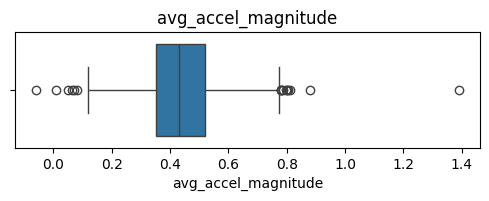

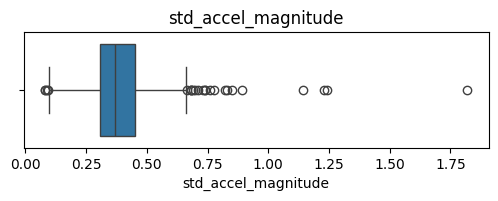

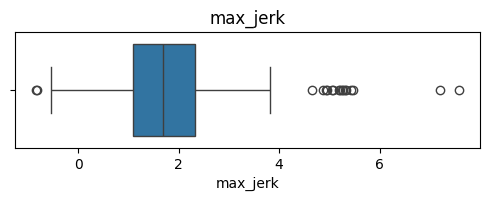

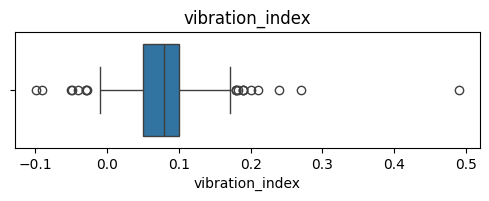

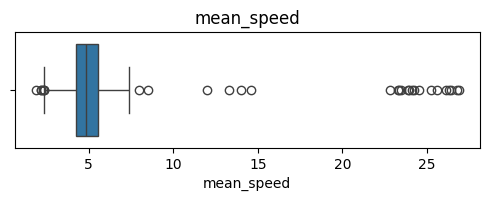

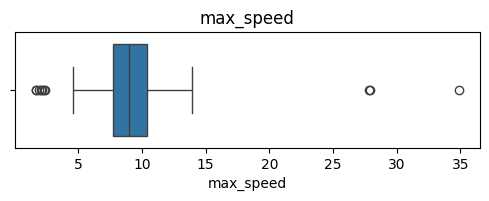

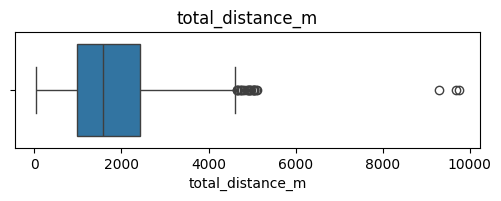

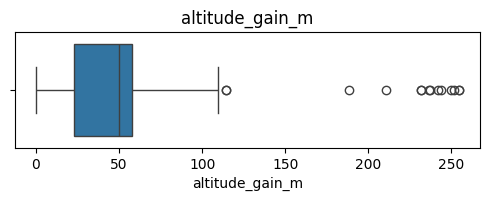

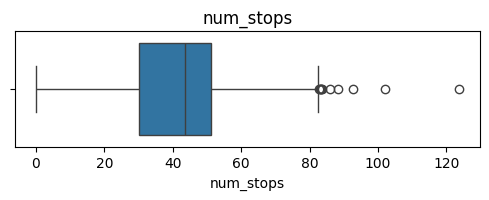

In [ ]:
cols = ['avg_accel_magnitude', 'std_accel_magnitude', 'max_jerk', 'vibration_index', 'mean_speed', 'max_speed', 'total_distance_m',
        'altitude_gain_m', 'num_stops']

for c in cols:
    plt.figure(figsize=(6,1.5))
    sns.boxplot(x=df[c])
    plt.title(c)
    plt.show()


## Clipping the outliers

In [ ]:
for c in cols:
    lower, upper = np.percentile(df[c], [1, 99])
    df[c] = np.clip(df[c], lower, upper)

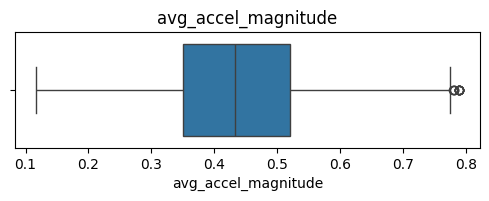

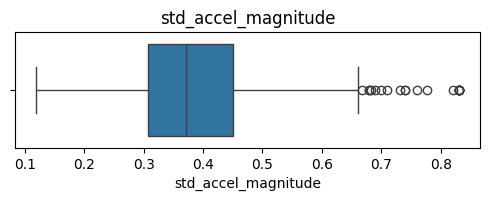

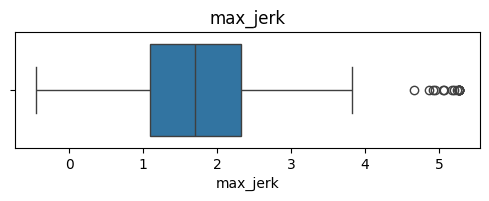

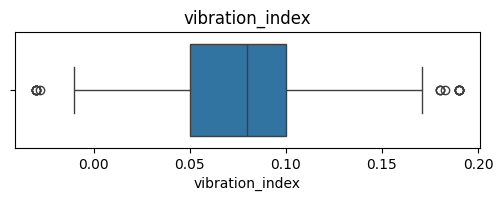

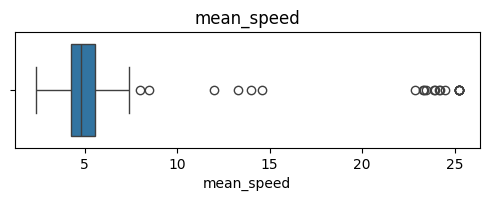

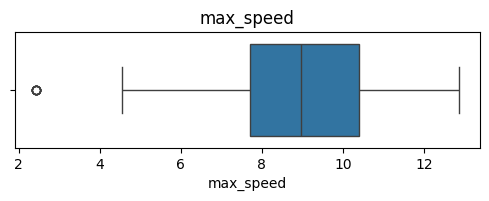

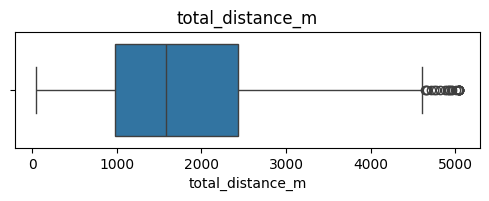

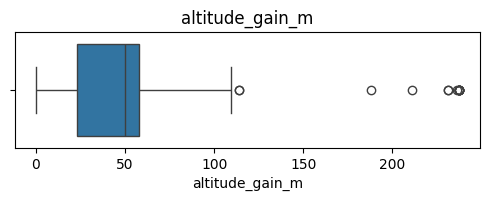

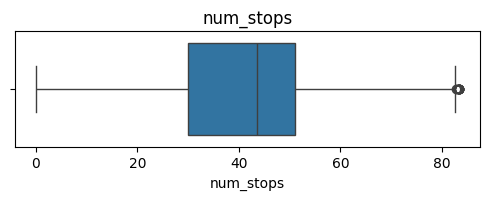

In [ ]:
for c in cols:
    plt.figure(figsize=(6,1.5))
    sns.boxplot(x=df[c])
    plt.title(c)
    plt.show()

Tree based models (like XGBoost , Random forest , LightBGM) are inherently robust to outliers in the input features but still we checked and capped accordingly and rest can be handled by my XGboost model which are robust to outliers and also there might be some geniuine pattern that can be learned by our model.

## Feature Engineering

In [ ]:
df['speed_variability'] = df['std_accel_magnitude'] / (df['mean_speed'] + 1e-5)

Speed variablility measures how much a rider's acceleration fluctuates compared to their average speed.In essence it captures the smoothness of a ride. Higher variablility means frequent acceleration-deaccelertation cycles , indicating aggressive or inconsistent driving.This will help detect potential brake and tire wear due to frequent speed changes.

In [ ]:
df['vibration_to_speed_ratio'] = df['vibration_index'] / (df['mean_speed'] + 1e-5)

This ratio compares overall vibration level of a bike to its average speed. If vibration is high even at low speeds it suggest possible issue in tire , brakes or suspension.

In [ ]:
df['stops_per_km'] = df['num_stops'] / ((df['total_distance_m'] / 1000) + 1e-5)

This represents how many times a rider stops per kilometer of distance travelled. It indicated braking frequency and riding pattern. High values imply frequent braaking which eventually increases brake and chain stress

In [ ]:
df['altitude_rate'] = df['altitude_gain_m'] / (df['total_distance_m'] + 1e-5)

Altitude rate shows how much elevation the bike gains per meter of distance.This features helps the model understands how terrain contributes to mechanical stress.

In [ ]:
df.head()

,ride_id,avg_accel_magnitude,std_accel_magnitude,max_jerk,vibration_index,mean_speed,max_speed,total_distance_m,altitude_gain_m,num_stops,...,timestamp_local,lat,lon,timezone,suspicious_flag,maintenance_log,speed_variability,vibration_to_speed_ratio,stops_per_km,altitude_rate
0,115.948,0.470,0.2150,0.042,0.083,4.63800,4.560,2891.674,13.117,37.48800,...,9/15/25 18:36,29.0910,82.0240,Asia/Kolkata,0.919,Good,0.046356,0.017896,12.964072,0.004536
1,185.715,0.163,0.2230,-0.431,0.053,5.00000,10.422,2473.232,75.220,51.82900,...,9/28/25 15:32,25.6150,80.4850,Asia/Kolkata,0.977,Brake_Risk,0.044600,0.010600,20.955895,0.030414
2,76.748,0.248,0.3940,2.507,0.084,25.22565,10.705,2466.011,32.459,16.23200,...,9/24/25 18:50,27.3850,80.6130,Asia/Kolkata,1.081,Multi_Risk,0.015619,0.003330,6.582263,0.013163
3,255.000,0.780,0.3500,1.920,0.060,5.53000,8.910,4175.980,0.000,40.00000,...,9/9/25 19:07,26.7606,83.3732,Asia/Kolkata,0.000,Good,0.063291,0.010850,9.578567,0.000000
4,63.000,0.220,0.8302,0.920,0.090,13.30000,10.750,695.210,43.840,83.33322,...,9/26/25 11:51,26.7606,83.3732,Asia/Kolkata,1.000,Tire_Risk,0.062421,0.006767,119.865970,0.063060


In [ ]:
df.drop(columns = ['lat','lon','timezone'] , inplace = True)

In [ ]:
df['weather'].unique()

array(['Rainy', 'Normal', 'Hot'], dtype=object)

###Encoding

In [ ]:
df['weather'] = df['weather'].map({'Rainy':0, 'Normal':1,'Hot':2}).astype(int)

In [ ]:
from sklearn.preprocessing import LabelEncoder

In [ ]:
le = LabelEncoder()
df['maintenance_log'] = le.fit_transform(df['maintenance_log'])

Since we are going to use tree based model, label encoding won't create any problem.

In [ ]:
df['weather'] = df['weather'].astype(float)
df['maintenance_log'] = df['maintenance_log'].astype(float)
df['suspicious_flag'] = df['suspicious_flag'].astype(float)

In [ ]:
df.head()

,ride_id,avg_accel_magnitude,std_accel_magnitude,max_jerk,vibration_index,mean_speed,max_speed,total_distance_m,altitude_gain_m,num_stops,weather,timestamp_local,suspicious_flag,maintenance_log,speed_variability,vibration_to_speed_ratio,stops_per_km,altitude_rate
0,115.948,0.470,0.2150,0.042,0.083,4.63800,4.560,2891.674,13.117,37.48800,0.0,9/15/25 18:36,0.919,1.0,0.046356,0.017896,12.964072,0.004536
1,185.715,0.163,0.2230,-0.431,0.053,5.00000,10.422,2473.232,75.220,51.82900,1.0,9/28/25 15:32,0.977,0.0,0.044600,0.010600,20.955895,0.030414
2,76.748,0.248,0.3940,2.507,0.084,25.22565,10.705,2466.011,32.459,16.23200,1.0,9/24/25 18:50,1.081,2.0,0.015619,0.003330,6.582263,0.013163
3,255.000,0.780,0.3500,1.920,0.060,5.53000,8.910,4175.980,0.000,40.00000,2.0,9/9/25 19:07,0.000,1.0,0.063291,0.010850,9.578567,0.000000
4,63.000,0.220,0.8302,0.920,0.090,13.30000,10.750,695.210,43.840,83.33322,1.0,9/26/25 11:51,1.000,3.0,0.062421,0.006767,119.865970,0.063060


This became necessary in order to have everything in float for my influxdb

### Train-Test Split

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report , confusion_matrix

In [ ]:
x = df.drop(columns = ['maintenance_log','timestamp_local','ride_id'])
y = df['maintenance_log']

In [ ]:
x_train , x_test , y_train , y_test = train_test_split(x,y,test_size = 0.2 , random_state = 42)

### Applying Standard Scaler

In [ ]:
scale_column = x_train.drop(columns = ['weather']).columns

In [ ]:
scaler = StandardScaler()
x_train[scale_column] = scaler.fit_transform(x_train[scale_column])
x_test[scale_column] = scaler.transform(x_test[scale_column])

## Checking for Imbalance

In [ ]:
y_train.value_counts()

,count
maintenance_log,
1.0,123
2.0,122
3.0,118
0.0,117


Since this data is heavily imbalanced therefore we need to balance it first before giving it to the model

In [ ]:
!pip install -U imbalanced-learn

In [ ]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)

In [ ]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42, k_neighbors=3)
x_train_res, y_train_res = smote.fit_resample(x_train, y_train)

print("Before SMOTE:", y_train.value_counts())
print("After SMOTE :", y_train_res.value_counts())

Before SMOTE: maintenance_log
1.0    123
2.0    122
3.0    118
0.0    117
Name: count, dtype: int64
After SMOTE : maintenance_log
1.0    123
0.0    123
3.0    123
2.0    123
Name: count, dtype: int64


# Applying XGBoost

In [ ]:
from xgboost import XGBClassifier

In [ ]:
xgb_model = XGBClassifier(objective = 'multi:softprob',random_state = 42 , eval_metrics = 'mlogloss')
xgb_model.fit(x_train_res,y_train_res)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [14:03:20] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "eval_metrics" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


,objective,'multi:softprob'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [ ]:
y_pred = xgb_model.predict(x_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        33
         1.0       0.90      0.96      0.93        27
         2.0       0.93      1.00      0.97        28
         3.0       0.96      0.84      0.90        32

    accuracy                           0.95       120
   macro avg       0.95      0.95      0.95       120
weighted avg       0.95      0.95      0.95       120



In [ ]:
proba = xgb_model.predict_proba(x_test)

In [ ]:
class_names = list(le.classes_)

proba_df = pd.DataFrame(proba, columns=[f"prob_{c}" for c in class_names])

true_labels = le.inverse_transform(y_test.astype(int))
pred_labels = le.inverse_transform(y_pred.astype(int))

results_df = pd.DataFrame({"True_Label": true_labels,"Predicted_Label": pred_labels})

results_df = pd.concat([results_df, proba_df], axis=1)

results_df.head()

,True_Label,Predicted_Label,prob_Brake_Risk,prob_Good,prob_Multi_Risk,prob_Tire_Risk
0,Tire_Risk,Tire_Risk,0.000133,0.000434,0.000653,0.998780
1,Multi_Risk,Multi_Risk,0.000877,0.000098,0.997995,0.001029
2,Tire_Risk,Tire_Risk,0.000600,0.000821,0.001500,0.997079
3,Tire_Risk,Tire_Risk,0.000090,0.000304,0.000464,0.999143
4,Tire_Risk,Tire_Risk,0.000862,0.001117,0.002139,0.995882


## Saving the model in pickle file

In [ ]:
import pickle, json

Trained Model

In [ ]:
pickle.dump(xgb_model, open("xgb_bike_model.pkl", "wb"))

The fitted Scaler

In [ ]:
pickle.dump(scaler, open("scaler.pkl", "wb"))

Class Name

In [ ]:
json.dump(list(le.classes_), open("class_names.json", "w"))

Numeric Column names

In [ ]:
json.dump(list(scale_column), open("numeric_cols.json", "w"))

 Full Feature Columns (Scaled Numeric + Encoded Weather)

In [ ]:
json.dump(list(scale_column) + ["weather"], open("feature_cols.json", "w"))

In [ ]:
!pip show scikit-learn

Name: scikit-learn
Version: 1.7.2
Summary: A set of python modules for machine learning and data mining
Home-page: https://scikit-learn.org
Author: 
Author-email: 
License: 
Location: /usr/local/lib/python3.12/dist-packages
Requires: joblib, numpy, scipy, threadpoolctl
Required-by: cuml-cu12, fastai, hdbscan, imbalanced-learn, libpysal, librosa, mlxtend, pynndescent, sentence-transformers, shap, sklearn-pandas, tsfresh, umap-learn, yellowbrick
